# Problem Session 3

## More Regression

The problems in this notebook will cover the content covered in our Regression lectures including:
- Multiple Linear Regression
- kNN Regression
- Categorical Variables and Interactions
- Pipelines

In [60]:
## We first load in packages we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as sklms
sns.set_style("whitegrid")

#### 1. Preparing the data

In this notebook you will continue to model the median selling price we started in the last problem session. First we have to load the data and repeat some of the cleaning we did in `Problem Session 2`.

##### a.

In [61]:
# Try to recall how to load the data without peeking.  It is in the data folder and is called housing.csv.
housing = pd.read_csv('housing.csv')
# drop the rows with null values
housing = housing.dropna()

def clean_column(text:str) -> float:
    text = text[1:] # removes leading $
    return float(text.replace(',','')) # removes comma and converts to float

# apply clean_column to the median house value.
housing.median_house_value = housing.median_house_value.apply(clean_column)

housing.info()

assert(housing.shape[0] == 20433)
assert(housing.median_house_value.dtype == float)

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


##### b.

Make the train test split using `sklearn`'s `train_test_split`.  Use an 80/20 split.  Use a random state of 216.

In [62]:
housing_train, housing_test = sklms.train_test_split(housing, test_size=0.2, random_state=216)

assert(housing_train.shape[0] == int(housing.shape[0]*0.8))

Remember that the data was truncated at an upper limit of $\$500000$ for the target variable.

In [63]:
# Set aside all of the rows for which the median house value is 500000
housing_truncated = housing[housing.median_house_value == 500000]
housing_train_truncated = housing_train[housing_train.median_house_value == 500000]
housing_test_truncated = housing_test[housing_test.median_house_value == 500000]

# Redefine these to only include the non-truncated examples
housing = housing[housing.median_house_value < 500000]
housing_train = housing_train[housing_train.median_house_value < 500000]
housing_test= housing_test[housing_test.median_house_value < 500000]

##### c.

If you need to, take a moment to refresh yourself on these data.

In [64]:
housing_train.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5112,-118.29,33.97,48.0,3139.0,587.0,1319.0,506.0,35208.0,134200.0,<1H OCEAN
4761,-118.35,34.04,49.0,1104.0,266.0,668.0,297.0,30856.0,151600.0,<1H OCEAN


#### 2. More EDA

In `Problem Session 2` you examined potential linear relationships with `median_house_value` and:
- `median_income`,
- `households`

In this notebook we will do a little feature engineering and also use the `ocean_proximity` categorical variable.

##### a. 

One way to examine if a categorical variable has an impact on an outcome variable is to compare the mean or median of the outcome variable among the different categories.

Use `pandas` `groupby`, <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html">https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html</a>, to examine the mean  `median_house_value` by the value of `ocean_proximity`.  Use the `.describe()` method.

In [65]:
housing_train['ocean_proximity'].describe()
housing_train.groupby(by='ocean_proximity').mean()['median_house_value']
# housing_train.groupby(by='ocean_proximity').median()['median_house_value']

ocean_proximity
<1H OCEAN     223837.785304
INLAND        123541.885852
ISLAND        388233.333333
NEAR BAY      234621.752266
NEAR OCEAN    227732.135417
Name: median_house_value, dtype: float64

##### b.

Another way to investigate the potential impact of categorical variables is to make plots examining the distribution of the outcome variable for each different category. 

Two common plots that are considered are box and whisker plots and violin plots. These can be made quickly using `seaborn`'s `boxplot`, <a href="https://seaborn.pydata.org/generated/seaborn.boxplot.html">https://seaborn.pydata.org/generated/seaborn.boxplot.html/</a>, and `violinplot`, <a href="https://seaborn.pydata.org/generated/seaborn.violinplot.html">https://seaborn.pydata.org/generated/seaborn.violinplot.html</a> functions.

Below we will look at the distribution of `median_house_income` by `ocean_proximity` using both.

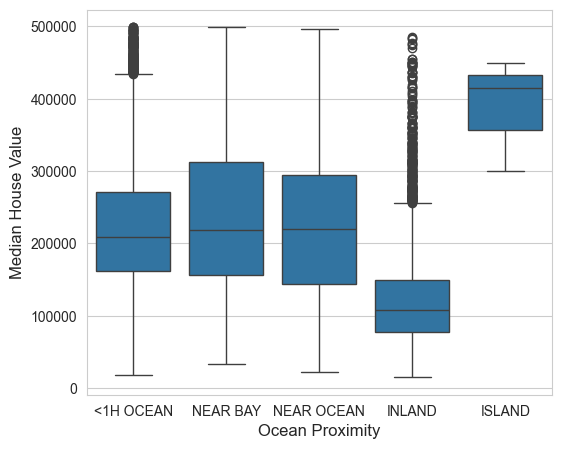

In [66]:
## Boxplot for ocean_proximity
plt.figure(figsize=(6,5))

sns.boxplot(data = housing_train,
               y = 'median_house_value',
               x = 'ocean_proximity')

plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.ylabel("Median House Value", fontsize=12)
plt.xlabel("Ocean Proximity", fontsize=12)

plt.show()

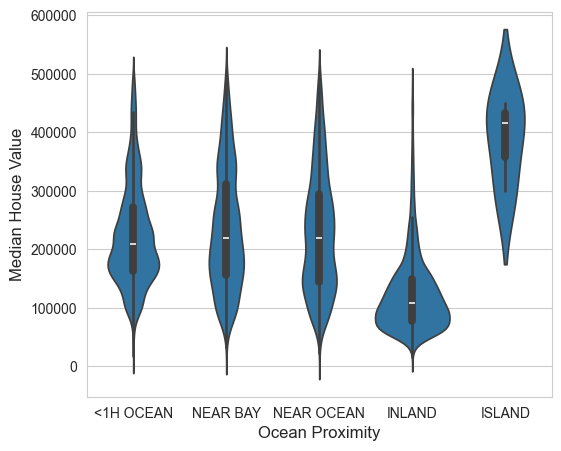

In [67]:
## violinplot for ocean_proximity
plt.figure(figsize=(6,5))

sns.violinplot(data = housing_train,
               y = 'median_house_value',
               x = 'ocean_proximity')

plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.ylabel("Median House Value", fontsize=12)
plt.xlabel("Ocean Proximity", fontsize=12)

plt.show()

##### c.

Discuss any thoughts you have about the `ocean_proximity` variable here.  Will you use all levels?  Will you combine some levels?
- I plan to combine 'NEAR BAY', 'NEAR OCEAN', and '<1H OCEAN'; they mean about the same thing and the means and medians of house values look to be very similar.
- 'INLAND' consistently predicts a lower value, with a few high outliers (likely from a few of the inland cities/wealthy towns).
- 'ISLAND' consistently predicts a very high value.

##### d.

From your investigations above you likely noticed that `INLAND` seems like a relevant predictor.

Create a new column in the data set called `INLAND` that is `1` if the `ocean_proximity` is `INLAND` and `0` otherwise.

In [68]:
housing_train['inland'] = 0
housing_train.loc[housing_train['ocean_proximity'] == 'INLAND', 'inland'] = 1
housing_train.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,inland
5112,-118.29,33.97,48.0,3139.0,587.0,1319.0,506.0,35208.0,134200.0,<1H OCEAN,0
4761,-118.35,34.04,49.0,1104.0,266.0,668.0,297.0,30856.0,151600.0,<1H OCEAN,0
9340,-122.59,37.99,36.0,4869.0,871.0,1899.0,827.0,41659.0,302000.0,NEAR BAY,0
5655,-118.30,33.74,23.0,3075.0,860.0,1584.0,806.0,29386.0,260500.0,NEAR OCEAN,0
2890,-118.98,35.39,29.0,607.0,177.0,476.0,143.0,11875.0,50700.0,INLAND,1
16494,-121.12,38.00,36.0,683.0,159.0,505.0,141.0,34265.0,158900.0,INLAND,1
3480,-118.52,34.29,28.0,2272.0,320.0,868.0,312.0,77464.0,474600.0,<1H OCEAN,0
465,-122.28,37.86,52.0,938.0,195.0,393.0,189.0,38594.0,196400.0,NEAR BAY,0
2563,-124.16,40.80,52.0,1703.0,500.0,952.0,435.0,11386.0,74100.0,NEAR OCEAN,0
6225,-117.93,34.05,32.0,3055.0,623.0,1902.0,565.0,42926.0,190700.0,<1H OCEAN,0


e. 

Rather than regressing on the total number of rooms, it seems a bit more sensible to use average number of rooms per household.  Create a new feature called `rooms_per_household`.

In [31]:
housing_train['rooms_per_household'] = housing_train['total_rooms']/housing_train['households']

#### 4. Comparing models

##### a.

Use cross validation to compare the following models:

* A simple linear regression on `median_income`
* A multiple linear regression using all of the features
* A kNN model using all of the features

##### b. 

Create a pipeline for a kNN model.  It should first standardize the features and then train a kNN model with $k=10$ on those standardized features.  Train the model on the first $80\%$ of the training data and evaluate it on the rest.

We are doing this before cross-validation for pedagogical reasons:  probably the first time you write a pipeline should not be inside a loop where it is a little harder to debug.

In [ ]:
housing_train.columns

In [15]:
features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income', 'INLAND',
       'rooms_per_household']

housing_train.dropna()

In [ ]:
housing_tt, housing_ho = sklms.train_test_split(housing_train, test_size=0.2, random_state=518)

In [ ]:
from sklearn.pipeline import 
from sklearn.preprocessing import 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics import root_mean_squared_error 

knn = KNeighborsRegressor()
knn.fit(housing_tt[['latitude', 'longitude']], housing_tt.median_house_value)

#housing_tt is the first 80% of the rows, housing_val is the last 80% of the rows
housing_tt = 
housing_val = 


val_predictions =
val_rmse = 
print(val_rmse)

##### c.

Perform 5-fold cross-validation to compare all of the models from 4a.

In [22]:
from sklearn.model_selection import 
from sklearn.linear_model import 

In [24]:
## Make a KFold object
## remember to set a random_state and set shuffle = True
num_splits = 5
num_models = 3
kfold = KFold(num_splits,
              random_state = 216,
              shuffle=True)


## This array will hold the mse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here


In [ ]:
rmses.mean(axis = 1), rmses.std(axis = 1)

Compare/Contrast the performance of these models.  How did they compare with the models from last week?

### BONUS

If you somehow still have time to work on a bonus activity, try this!

Fill in the blanks for the class called `KNN_then_Linear` below which first fits a KNN model to one subset of the features and then fits a linear model to the residuals of the KNN model using another subset of the features.

This is a simple example of a strategy called "boosting" which we will cover in more depth later.

What is the cross validation rmse of this model when we use lat/lon for the KNN features and median income and INLAND for the linear feature?

In [ ]:
class KNN_then_Linear():
    def __init__(self, knn_features, linear_features, n_neighbors = 10):
        '''
        knn_features: A list of feature names for knn
        linear_features: A list of feature names for linear regression on the residuals of the knn model
        n_neighbors: The number of neighbors used by knn
        '''
        self.knn = None
        self.linear = None
        self.n_neighbors = n_neighbors
        self.knn_features = knn_features
        self.linear_features = linear_features
    def fit(self,X,y):
        '''
        X:  A pandas dataframe.  It must have all features in knn_features and linear_features
        y:  A pandas series.
        '''
        # Instantiate knn model object
        self.knn = 
        # Fit self.knn

        # Get the predictions
        predictions = 

        # Get the residuals
        residuals = 

        # Instantiate the linear regression model object
        self.linear = 

        # Fit self.linear using the residuals as targets.
        

    def predict(self,X):
        '''
        X:  A pandas dataframe.  It must have all features in knn_features and linear_features
        returns: the prediction of the model on X
        '''
        # Should return the sum of the predictions from self.knn and self.linear
        return 

In [ ]:
num_splits = 5
kfold = KFold(num_splits,
              random_state = 216,
              shuffle=True)

rmses_ktl = np.zeros(num_splits)

i=0
for train_index, test_index in kfold.split(housing_train):
    ## cv training set
    housing_tt = housing_train.iloc[train_index]
    
    ## cv holdout set
    housing_ho = housing_train.iloc[test_index]
      
    ## Fit and get ho mse for mlr model
    ktl = KNN_then_Linear(knn_features=['latitude','longitude'], linear_features=['median_income', 'INLAND'])
    
    ktl.fit(housing_tt[['latitude','longitude', 'median_income', 'INLAND']], housing_tt.median_house_value)    
    rmses_ktl[i] = root_mean_squared_error(housing_ho.median_house_value, ktl.predict(housing_ho[['latitude','longitude', 'median_income', 'INLAND']]))
    i = i + 1

In [ ]:
rmses_ktl.mean()

Our best performing model yet!

--------------------------

This notebook was written for the Erdős Institute Data Science Boot Camp by Steven Gubkin.

Please refer to the license in this repo for information on redistribution.